<h1 style="margin-bottom:0"><center>IS 583 - Social Media Analytics</center></h1>
<h2 style="margin-top:0"><center>Assignment 2</center></h2>
<br>
<p style="margin-top:0"><left><b>Ezgi Tunali - 2095693</b></center></p>

In [24]:
#!pip3 install snscrape
#!pip3 install sklearn
#!pip3 install scikit-posthocs
#!pip3 install scikit-learn
#!pip3 install pingouin

In [39]:
from sklearn import preprocessing
import scikit_posthocs as sp
import numpy as np
from scipy import stats
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format

In [40]:
import snscrape.modules.twitter as sntwitter #We import only the Twitter module
import pandas as pd
import datetime
from datetime import datetime


<h2 style="margin-top:0">Dataset Creation</h2>

In [3]:

friends_tweets_list = []
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:FriendsTV since:2020-06-01 until:2022-11-01 lang:en').get_items()): #declare a username 
   friends_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
friends_tweets_df = pd.DataFrame(friends_tweets_list, columns=['Datetime', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [4]:
himym_tweets_list = []
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:OfficialHIMYM since:2020-06-01 until:2022-11-01 lang:en').get_items()): #declare a username 
    himym_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
himym_tweets_df = pd.DataFrame(himym_tweets_list, columns=['Datetime', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [5]:
friends_tweets_df.to_json('friends_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')
himym_tweets_df.to_json('himym_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [41]:
friends_tweets_df = pd.read_json('friends_tweets_original.json', orient ='split', compression = 'infer')
himym_tweets_df = pd.read_json('himym_tweets_original.json', orient ='split', compression = 'infer')

In [42]:
#len(himym_tweets_df)
#len(friends_tweets_df)
#himym_tweets_df.head(2)
#friends_tweets_df.head(10)

In [43]:
himym_tweets_df.describe()

,Like Count,Retweet Count,Reply Count
count,220.0000,220.0000,220.0000
mean,"3,450.3955",412.8545,60.4591
std,"3,121.7427",569.7637,160.6679
min,0.0000,0.0000,0.0000
25%,"1,469.5000",75.7500,9.7500
50%,"2,990.5000",205.5000,17.0000
75%,"4,726.0000",581.5000,39.5000
max,"19,368.0000","5,259.0000","1,280.0000"


In [44]:
friends_tweets_df.describe()

,Like Count,Retweet Count,Reply Count
count,379.0000,379.0000,379.0000
mean,"5,030.3668",706.7520,66.1689
std,"8,929.4138","1,975.8028",368.9321
min,4.0000,0.0000,0.0000
25%,804.5000,51.5000,10.0000
50%,"2,332.0000",200.0000,23.0000
75%,"6,191.5000",596.5000,46.5000
max,"126,230.0000","27,924.0000","6,803.0000"


Outlier Elimination According to Interquartile Range

In [45]:
''' Detection '''
# IQR
Q1f = np.percentile(friends_tweets_df['Like Count'], 25,
				interpolation = 'midpoint')
Q3f = np.percentile(friends_tweets_df['Like Count'], 75,
				interpolation = 'midpoint')
IQRf = Q3f - Q1f

In [46]:
''' Detection '''
# IQR
Q1h = np.percentile(himym_tweets_df['Like Count'], 25,
				interpolation = 'midpoint')
Q3h = np.percentile(himym_tweets_df['Like Count'], 75,
				interpolation = 'midpoint')
IQRh = Q3h - Q1h

In [47]:
# Upper bound
upperscoref = (Q3f+1.5*IQRf)
#print(upperscoref)
# Lower bound
lowerscoref = (Q1f-1.5*IQRf)
#print(lowerscoref)
upperscoreh = (Q3h+1.5*IQRh)
#print(upperscoreh)
lowerscoreh = (Q1h-1.5*IQRh)
#print(lowerscoreh)                                 

In [48]:
friends_tweets_df = friends_tweets_df.drop(friends_tweets_df[friends_tweets_df['Like Count'] > upperscoref].index)
friends_tweets_df = friends_tweets_df.drop(friends_tweets_df[friends_tweets_df['Like Count'] < lowerscoref].index)

In [49]:
#len(friends_tweets_df)

In [50]:
himym_tweets_df = himym_tweets_df.drop(himym_tweets_df[himym_tweets_df['Like Count'] > upperscoreh].index)
himym_tweets_df = himym_tweets_df.drop(himym_tweets_df[himym_tweets_df['Like Count'] < lowerscoreh].index)

In [51]:
#len(himym_tweets_df)

In [52]:
himym_tweets_df = himym_tweets_df.reset_index(drop=True)
friends_tweets_df = friends_tweets_df.reset_index(drop=True)

In [53]:
#preprocessing 
#lowercase conversion, so that character names search can be fully done 
friends_tweets_df["Modified_Text"] = friends_tweets_df["Text"].apply(lambda x: " ".join(x.lower() for x in x.split()))
himym_tweets_df["Modified_Text"] = himym_tweets_df["Text"].apply(lambda x: " ".join(x.lower() for x in x.split()))


<h4 style="margin-bottom:0">RQ1) Considering like counts, is there a significant popularity difference between Friends and HIMYM?</h4>

Rejecting H₀ validates H₁.
</br>
However failing to reject H₀ doesnt prove H₀ is valid or H₁ is wrong

</br>
Here the datasets are independent, they are from different accounts. They are not normally distributed

In [54]:
#H₀: data is normally distributed
#H₁: data is not normally distributed

def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.8f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed") 

In [55]:
#H₀: variances of samples are same
#H₁: variances of samples are not same

def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.8f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")


I tried standardizing the like counts using cumulative range, as follows. however, it didnt affect the statistical tests' results
</br>
</br>
from sklearn.preprocessing import MinMaxScaler </br>
from sklearn.preprocessing import StandardScaler </br>
from sklearn.decomposition import PCA </br>
</br>
h_array = (np.array(himym_tweets_df['Like Count'])).reshape(-1,1) </br>
f_array = np.array(friends_tweets_df['Like Count']).reshape(-1,1) </br>
likes_array = np.append(h_array, f_array)
</br>
standardizer = StandardScaler() </br>
standardized_likes = standardizer.fit_transform(likes_array.reshape(-1, 1)) </br>
standardized_himym_likes = standardized_likes[0:len(h_array)] </br>


In [56]:
#check_normality(standardized_friends_likes)
#check_normality(standardized_himym_likes)

In [57]:
himym_tweets_df['Like Count'] = himym_tweets_df['Like Count'].astype(int)
friends_tweets_df['Like Count'] = friends_tweets_df['Like Count'].astype(int)

himym_likes = himym_tweets_df['Like Count']
friends_likes = friends_tweets_df['Like Count']

check_normality(himym_likes)
check_normality(friends_likes)


p value:0.00000047
Reject null hypothesis >> The data is not normally distributed
p value:0.00000000
Reject null hypothesis >> The data is not normally distributed


In [58]:
#himym_tweets_df['Like Count'].hist(grid=True, color='#EEE0E5') - right skewed
#friends_tweets_df['Like Count'].hist(grid=True, color='#EEE0E5') - right skewed

using stats or pingouing library doesn't change the results

In [59]:
#H₀: there is no statistically significant difference between means distributions
#H₁: there is statistically significant difference between means distributions

#both have same distribution - right skewed. they are not normally distributed
#unpaired datasets, same distribution we can user mann-whitney test

ttest,pvalue = stats.mannwhitneyu(friends_tweets_df['Like Count'],himym_tweets_df['Like Count'], alternative="two-sided")
#ttest,pvalue = stats.mannwhitneyu(standardized_friends_likes,standardized_himym_likes, alternative="two-sided")
print("p-value:%.4f" % pvalue)
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis - likes distributions are not significantly different")
    
#the probability of getting a sufficiently low value of the test statistic by chance under the null hypothesis is greater than 5%, so we do not reject the null hypothesis in favor of our alternative.

p-value:0.6437
Fail to reject null hypothesis - likes distributions are not significantly different


In [60]:
import pingouin

himym_tweets_df['series'] = "himym"
friends_tweets_df['series'] = "friends"
likes_df = himym_tweets_df[['series','Like Count']].append(friends_tweets_df[['series', 'Like Count']])
likes_df_wide = likes_df.pivot(columns = 'series', values = 'Like Count')
#likes_df_wide
pingouin.mwu(x = likes_df_wide['friends'], y = likes_df_wide['himym'], alternative = 'two-sided')

/var/folders/5y/1lbj6yd54437j449qqbvhdf40000gq/T/ipykernel_47774/805734469.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  likes_df = himym_tweets_df[['series','Like Count']].append(friends_tweets_df[['series', 'Like Count']])


,U-val,alternative,p-val,RBC,CLES
MWU,"35,720.0000",two-sided,0.6437,0.0234,0.4883


In [61]:
#ttest,pvalue = stats.mannwhitneyu(standardized_friends_likes,standardized_himym_likes, alternative="less")
ttest,pvalue = stats.mannwhitneyu(friends_tweets_df['Like Count'],himym_tweets_df['Like Count'], alternative="less")
print("p-value:%.4f" % pvalue)
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p-value:0.3219
Fail to reject null hypothesis


In [62]:
#ttest,pvalue = stats.mannwhitneyu(standardized_friends_likes,standardized_himym_likes, alternative="greater")
ttest,pvalue = stats.mannwhitneyu(friends_tweets_df['Like Count'],himym_tweets_df['Like Count'], alternative="greater")
print("p-value:%.4f" % pvalue)
if pvalue <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p-value:0.6783
Fail to reject null hypothesis


the probabilities of getting a sufficiently low value of the test statistic by chance under the null hypotheses are all greater than 5%, so we do not reject the null hypothesis in favor of any of our alternatives.
</br>
still saying that friends have less likes than himym is more sensible than vice versa as type I error is smaller. #bunu yanlış yaptım sanırım. friends < himym rejecte daha yakın aslında. 

</br> 
considering popularity by the tweets' likecounts of the official twitter accounts; we can say that there is no significant popularity difference. as like distributions of two series' tweets are not significantly different. this is drawn by the two-sided mannwhitney test, which is parallel to the research quesiton and considers the difference regardless of the sign of the difference

<h4 style="margin-bottom:0">RQ2) Considering like counts, is there a significant popularity difference between Friends characters?</h4> 
</br> - Is there a correlation between charachter pairs or statistically significant dependence on likes-tweets number ?

In [63]:
chandler = []
monica = []
joey = []
ross = []
phoebe = []
rachel = []

In [64]:
i = 0
for i in range(len(friends_tweets_df)):
    if "chandler" in friends_tweets_df['Modified_Text'][i]:
        chandler.append(friends_tweets_df['Like Count'][i])
    if "monica" in friends_tweets_df['Modified_Text'][i]:
        monica.append(friends_tweets_df['Like Count'][i])
    if "ross" in friends_tweets_df['Modified_Text'][i]:
        ross.append(friends_tweets_df['Like Count'][i])
    if "phoebe" in friends_tweets_df['Modified_Text'][i]:
        phoebe.append(friends_tweets_df['Like Count'][i])
    if "joey" in friends_tweets_df['Modified_Text'][i]:
        joey.append(friends_tweets_df['Like Count'][i])
    if "rachel" in friends_tweets_df['Modified_Text'][i]:
        rachel.append(friends_tweets_df['Like Count'][i])    
    i = i+1

for not-normal distributions, with more than 2 groups Kruskal-Wallis can be used. It is the non-parametric version of ANOVA
</br> The normality assumption is not satisfied, 

In [65]:
#variance test
#H₀: The variance of the samples is the same.
#H₁: At least one of them is different.

stat, pvalue_lev= stats.levene(chandler, ross, joey, monica, phoebe, rachel)

print("p value:%.4f" % pvalue_lev)
if pvalue_lev <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.3877
Fail to reject null hypothesis >> The variances of the samples are same.


In [66]:
#H₀: The mean of the samples is the same.
#H₁: At least one of them is different.

F, p_value = stats.kruskal(chandler, ross, joey, monica, phoebe, rachel)
print("p value:%.6f" % p_value)
if p_value <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis >> There is no statistically significant difference between distributions") #same 

p value:0.158589
Fail to reject null hypothesis >> There is no statistically significant difference between distributions


p value is high, at least small difference can be observed by posthoc.mannwhitney

In [67]:
posthoc_df = sp.posthoc_mannwhitney([chandler, ross, joey, monica, phoebe, rachel], p_adjust = 'bonferroni')
#mannwhitneyde ordinally scaled olmalı diyor slayt.
group_names= ["chandler", "ross", "joey", "monica", "phoebe", "rachel"]
posthoc_df.columns= group_names
posthoc_df.index= group_names
posthoc_df.style.applymap(lambda x: "background-color:violet" if x<0.05 else "background-color: white")

,chandler,ross,joey,monica,phoebe,rachel
chandler,1.000000,0.412269,1.000000,1.000000,1.000000,1.000000
ross,0.412269,1.000000,0.253652,1.000000,1.000000,1.000000
joey,1.000000,0.253652,1.000000,1.000000,1.000000,1.000000
monica,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
phoebe,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rachel,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


as these tweets are collected from official Friends account, comparing related likes count rather than related tweet numbers seemed more sensible to me

I also wanted to check the tweet distributions from different personal accounts and see charachter-wise correlation 


Datasets Creation

In [101]:
#chandlerbing_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'chandler bing' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    chandlerbing_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#chandlerbing_tweets_df = pd.DataFrame(chandlerbing_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [40]:
#chandlerbing_tweets_df.to_json('chandlerbing_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [8]:
#monicag_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'monica geller' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    monicag_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#monicag_tweets_df = pd.DataFrame(monicag_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [13]:
#monicag_tweets_df.to_json('monicag_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [12]:
#joeyt_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'joey tribbiani' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    joeyt_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#joeyt_tweets_df = pd.DataFrame(joeyt_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [14]:
#joeyt_tweets_df.to_json('joeyt_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [15]:
#rossg_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'ross geller' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    rossg_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#rossg_tweets_df = pd.DataFrame(rossg_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [16]:
#rossg_tweets_df.to_json('rossg_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [17]:
#phoebeb_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'phoebe buffay' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    phoebeb_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#phoebeb_tweets_df = pd.DataFrame(phoebeb_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [18]:
#phoebeb_tweets_df.to_json('phoebeb_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

In [22]:
#rachelg_tweets_list = []
#for i,tweet in enumerate(sntwitter.TwitterSearchScraper("'rachel green' since:2022-06-01 until:2022-06-07 lang:en").get_items()): #declare a username 
#    rachelg_tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.hashtags, tweet.likeCount, tweet.retweetCount, tweet.replyCount]) #declare the attributes to be returned
#rachelg_tweets_df = pd.DataFrame(rachelg_tweets_list, columns=['Date', 'Text', 'Username', 'Hashtags', 'Like Count', 'Retweet Count', 'Reply Count'])

In [23]:
#rachelg_tweets_df.to_json('rachelg_tweets_original.json', orient = 'split', compression = 'infer', index = 'true')

Datasets Read

In [68]:
chandlerbing_tweets_df = pd.read_json('chandlerbing_tweets_original.json', orient ='split', compression = 'infer')
monicag_tweets_df = pd.read_json('monicag_tweets_original.json', orient ='split', compression = 'infer')
joeyt_tweets_df = pd.read_json('joeyt_tweets_original.json', orient ='split', compression = 'infer')
rachelg_tweets_df = pd.read_json('rachelg_tweets_original.json', orient ='split', compression = 'infer')
rossg_tweets_df = pd.read_json('rossg_tweets_original.json', orient ='split', compression = 'infer')
phoebeb_tweets_df = pd.read_json('phoebeb_tweets_original.json', orient ='split', compression = 'infer')


In [69]:
#chandlerbing_tweets_df.head()

In [70]:
monicag_tweets_df['Date'] = pd.to_datetime(monicag_tweets_df["Date"]).dt.date
chandlerbing_tweets_df['Date'] = pd.to_datetime(chandlerbing_tweets_df["Date"]).dt.date
joeyt_tweets_df['Date'] = pd.to_datetime(joeyt_tweets_df["Date"]).dt.date
phoebeb_tweets_df['Date'] = pd.to_datetime(phoebeb_tweets_df["Date"]).dt.date
rachelg_tweets_df['Date'] = pd.to_datetime(rachelg_tweets_df["Date"]).dt.date
rossg_tweets_df['Date'] = pd.to_datetime(rossg_tweets_df["Date"]).dt.date

In [71]:
chandlerbing_tweets_df['TweetCount'] = 1
monicag_tweets_df['TweetCount'] =1
chandlerbing_tweets_df['TweetCount'] = 1
joeyt_tweets_df['TweetCount'] = 1
phoebeb_tweets_df['TweetCount'] = 1
rachelg_tweets_df['TweetCount'] = 1
rossg_tweets_df['TweetCount'] = 1

In [72]:
monica_timeseries = monicag_tweets_df.groupby('Date', as_index= False).sum()
chandlerbing_timeseries = chandlerbing_tweets_df.groupby('Date', as_index= False).sum()
rachelg_timeseries = rachelg_tweets_df.groupby('Date', as_index= False).sum()
joeyt_timeseries = joeyt_tweets_df.groupby('Date', as_index= False).sum()
rachelg_timeseries = rachelg_tweets_df.groupby('Date', as_index= False).sum()
rossg_timeseries = rossg_tweets_df.groupby('Date', as_index= False).sum()
phoebeb_timeseries = phoebeb_tweets_df.groupby('Date', as_index= False).sum()

In [73]:
datedata = monica_timeseries['Date']
likesdf = pd.DataFrame(datedata)
tweetsdf = pd.DataFrame(datedata)

In [74]:
monica_timeseries

,Date,Like Count,Retweet Count,Reply Count,TweetCount
0,2022-06-01,63,7,6,11
1,2022-06-02,1290,123,8,15
2,2022-06-03,16,0,3,14
3,2022-06-04,58,0,10,9
4,2022-06-05,779,58,0,12
5,2022-06-06,12730,2138,9,14


In [75]:
likesdf['MonicaLike'] = monica_timeseries['Like Count']
likesdf['ChandlerLike'] = chandlerbing_timeseries['Like Count']
likesdf['RossLike'] = rossg_timeseries['Like Count']
likesdf['RachelLike'] = rachelg_timeseries['Like Count']
likesdf['PheobeLike'] = phoebeb_timeseries['Like Count']
likesdf['JoeyLike'] = joeyt_timeseries['Like Count']

In [76]:
tweetsdf['MonicaLike'] = monica_timeseries['TweetCount']
tweetsdf['ChandlerLike'] = chandlerbing_timeseries['TweetCount']
tweetsdf['RossLike'] = rossg_timeseries['TweetCount']
tweetsdf['RachelLike'] = rachelg_timeseries['TweetCount']
tweetsdf['PheobeLike'] = phoebeb_timeseries['TweetCount']
tweetsdf['JoeyLike'] = joeyt_timeseries['TweetCount']

In [77]:
import seaborn as sn
import matplotlib.pyplot as plt

In [78]:
tweetsdf

,Date,MonicaLike,ChandlerLike,RossLike,RachelLike,PheobeLike,JoeyLike
0,2022-06-01,11,46,29,31,24,16
1,2022-06-02,15,43,15,22,19,13
2,2022-06-03,14,58,24,21,25,23
3,2022-06-04,9,32,18,40,16,16
4,2022-06-05,12,42,18,21,33,18
5,2022-06-06,14,38,15,24,12,14


<AxesSubplot:>

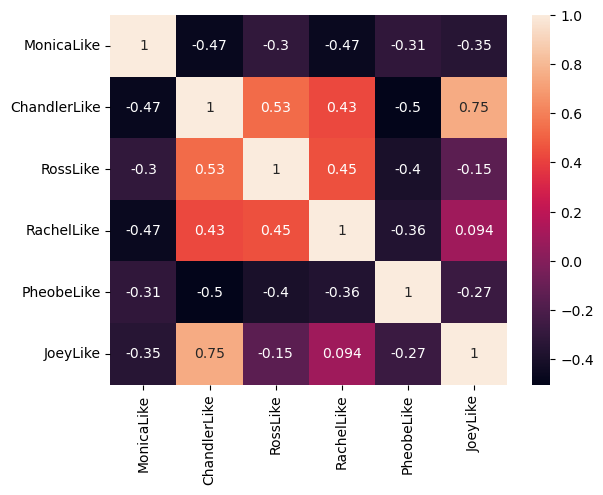

In [79]:
corr_matrix = likesdf.corr()
sn.heatmap(corr_matrix, annot=True)

Chi-square is a simple test statistic that permits you to assess if relationships between two variables in a sample are due to chance or the relationship is systematic.

In [80]:
chi = pd.crosstab(likesdf['JoeyLike'], likesdf['ChandlerLike'] , margins=True)


In [81]:
chit = pd.crosstab(likesdf['JoeyLike'], tweetsdf['JoeyLike'] , margins=True)

In [82]:
chi2, p, dof, ex = stats.chi2_contingency(chi)
print("p value:%.4f" % p)
if p <0.05:    
    print("Reject null hypothesis >> Likes of joey_tweets is not independent of chandler_tweets")
else:
    print("Fail to reject null hypothesis >> Likes of joey_tweets is independent of chandler_tweets")

p value:0.7489
Fail to reject null hypothesis >> Likes of joey_tweets is independent of chandler_tweets


In [83]:
chi2, p, dof, ex = stats.chi2_contingency(chit)
print("p value:%.4f" % p)
if p <0.05:    
    print("Reject null hypothesis >> Likes of joey_tweets is not independent of number of joey_tweets")
else:
    print("Fail to reject null hypothesis >> Likes of joey_tweets is independent of number of joey_tweets")

p value:0.7720
Fail to reject null hypothesis >> Likes of joey_tweets is independent of number of joey_tweets
